Install the library from this branch, execute the next two cells and restart the kernel.

In [30]:
!rm -rf /srv/conda/envs/notebook/lib/python3.10/site-packages/earthaccess*
%pip install git+https://github.com/nsidc/earthaccess.git@auth-improvements --quiet

Note: you may need to restart the kernel to use updated packages.


In [81]:
%pip install pyhdf

  Using cached pyhdf-0.10.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (739 kB)
Note: you may need to restart the kernel to use updated packages.


In [31]:
import earthaccess
print(f"Using earthaccess v{earthaccess.__version__}")

#### Log into NASA's Earth Data using the earthaccess package

A netrc file will allow your credentials to persist after this one time that you put in your credentials. If you don't want these credentials saved for any reason, remove `persist=True`.

In [48]:
# Search for a .netrc file to authenticate, if none available, request credentials manually
auth = earthaccess.login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

We are already authenticated with NASA EDL
Using earthaccess v0.5.1


#### Search for cloud-available datasets from NASA

In [226]:
# Using a keyword search

from pprint import pprint
datasets = earthaccess.search_datasets(keyword="SENTINEL",
                                       cloud_hosted=True)

for dataset in datasets[0:2]:
    pprint(dataset.summary())

Datasets found: 129
{'cloud-info': {'Region': 'us-west-2', 'S3BucketAndObjectPrefixNames': [' s3://lp-prod-protected/HLSS30.020', 's3://lp-prod-public/HLSS30.020'], 'S3CredentialsAPIEndpoint': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials', 'S3CredentialsAPIDocumentationURL': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentialsREADME'},
 'concept-id': 'C2021957295-LPCLOUD',
 'file-type': "[{'Format': 'Cloud Optimized GeoTIFF (COG)', 'FormatType': "
              "'Native'}]",
 'get-data': ['https://search.earthdata.nasa.gov/search?q=C2021957295-LPCLOUD',
              'https://appeears.earthdatacloud.nasa.gov/'],
 'short-name': 'HLSS30',
 'version': '2.0'}
{'concept-id': 'C1595422627-ASF',
 'file-type': '',
 'get-data': [],
 'short-name': 'SENTINEL-1_INTERFEROGRAMS',
 'version': '1'}


In [168]:
# Using a known short name
datasets = earthaccess.search_datasets(short_name="HLSS30",
                                       cloud_hosted=True)
for dataset in datasets:
    pprint(dataset.summary())
    pprint(dataset.abstract())

Datasets found: 1
{'cloud-info': {'Region': 'us-west-2', 'S3BucketAndObjectPrefixNames': [' s3://lp-prod-protected/HLSS30.020', 's3://lp-prod-public/HLSS30.020'], 'S3CredentialsAPIEndpoint': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials', 'S3CredentialsAPIDocumentationURL': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentialsREADME'},
 'concept-id': 'C2021957295-LPCLOUD',
 'file-type': "[{'Format': 'Cloud Optimized GeoTIFF (COG)', 'FormatType': "
              "'Native'}]",
 'get-data': ['https://search.earthdata.nasa.gov/search?q=C2021957295-LPCLOUD',
              'https://appeears.earthdatacloud.nasa.gov/'],
 'short-name': 'HLSS30',
 'version': '2.0'}
('The Harmonized Landsat Sentinel-2 (HLS) project provides consistent surface '
 'reflectance data from the Operational Land Imager (OLI) aboard the joint '
 'NASA/USGS Landsat 8 satellite and the Multi-Spectral Instrument (MSI) aboard '
 'Europe’s Copernicus Sentinel-2A and Sentinel-2B satellites. The combined '
 'm

### Searching for granules (files) from a given collection (dataset)
Earthaccess has 2 different ways of querying for data. We can build a query object or we can use the top level API. The difference is that the query object is a bit more flexible and we don't retrieve the metadata from CMR until we execute the `.get()` or `.get_all()` methods.

Let's use [bboxfinder.com](http://bboxfinder.com) to get the extent of our bounding box and enter it into our bounding box input below. You are also welcome to put in a bounding box you already have available. You can uncomment the Iceland bounding box if you don't want to find your own. Order should be: `min_lon, min_lat, max_lon, max_lat`

In [153]:
# Using a specific concept-id, which is unique to the specific product and version

# bbox for ~Iceland is -22.1649, 63.3052, -11.9366, 65.5970 
granules_query = earthaccess.granule_query().cloud_hosted(True) \
        .concept_id("C2021957295-LPCLOUD") \
        .bounding_box(-22.1649, 63.3052, -11.9366, 65.5970) \
        .temporal("2020-01-01","2023-01-01")
granules_query.params

{'concept_id': ['C2021957295-LPCLOUD'],
 'bounding_box': '-22.1649,63.3052,-11.9366,65.597',
 'temporal': ['2020-01-01T00:00:00Z,2023-01-01T00:00:00Z']}

In [154]:
granules_query.hits()

4739

Earthaccess has many methods we can use for our search. For a complete list of the parameters we can use, go to [https://nsidc.github.io/earthaccess/user-reference/granules/granules-query/](https://nsidc.github.io/earthaccess/user-reference/granules/granules-query/)

In [155]:
granule = granules_query.get(1)[0]
granule.data_links()

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28WET.2020151T123311.v2.0/HLS.S30.T28WET.2020151T123311.v2.0.B05.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28WET.2020151T123311.v2.0/HLS.S30.T28WET.2020151T123311.v2.0.B02.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28WET.2020151T123311.v2.0/HLS.S30.T28WET.2020151T123311.v2.0.B08.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28WET.2020151T123311.v2.0/HLS.S30.T28WET.2020151T123311.v2.0.VAA.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28WET.2020151T123311.v2.0/HLS.S30.T28WET.2020151T123311.v2.0.B04.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28WET.2020151T123311.v2.0/HLS.S30.T28WET.2020151T123311.v2.0.SZA.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30

### Downloading granules

##### **IMPORTANT**: Some datasets will require users to accept an EULA (end user license agreement), it is advisable trying to download a single granule using our browser first and see if we get redirected to a NASA form.

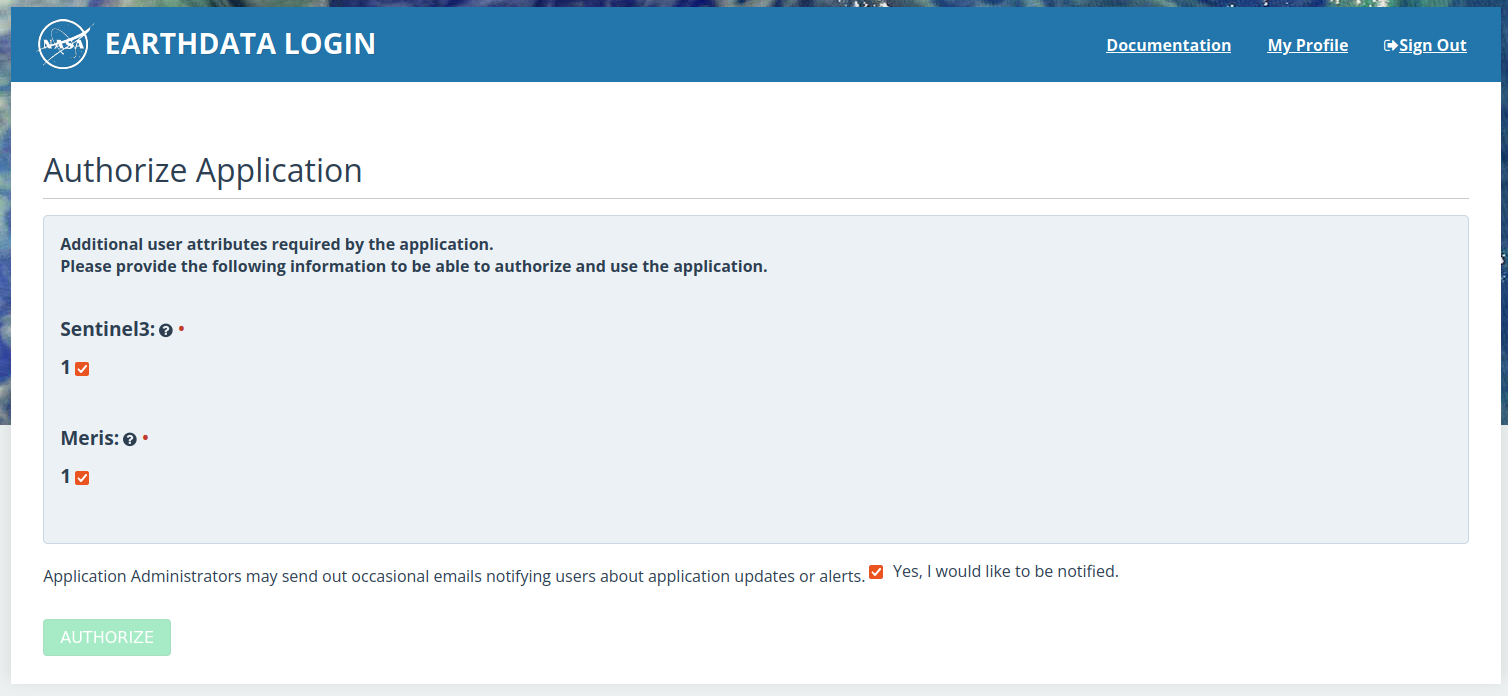


We can now download the granules in batches, in this case per year or we can pick some for each season depending on our needs.

In [157]:
# we are using a bounding box but we can also use a polygon or a point
iceland_bbox = (-22.1649, 63.3052, -11.9366, 65.5970)

for year in range(2020, 2023):
    print(f"Querying {year}")
    granules = earthaccess.search_data(
        short_name = "HLSS30",
        bounding_box = iceland_bbox,
        temporal = (f"{year}-01", f"{year+1}-01")
    )
    # If we really want to download the HDF files we can uncomment the next line
    # earthaccess.download(granules, f"MOD07_L2/{year}")

Querying 2020
Granules found: 1092
Querying 2021
Granules found: 1871
Querying 2022
Granules found: 1776


### Streaming data with earthaccess
If we have enough RAM (memory), we can load our granules from an S3 bucket into memory. Earthaccess works with fsspec (xarray, h5netcdf) at the moment, so this is task is better suited for Level 3 and Level 4 netcdf datasets.

We are going to select a few granules for the same day in January for 10 years.

In [169]:
iceland_bbox = (-22.1649, 63.3052, -11.9366, 65.5970)
# we are going to save our granules for each year on this list
granule_list = []

for year in range(2018, 2023):
    print(f"Querying {year}")
    granules = earthaccess.search_data(
        short_name = "HLSS30",
        bounding_box = iceland_bbox,
        temporal = (f"{year}-02-17", f"{year}-02-18")
    )
    granule_list.extend(granules)

Querying 2018
Granules found: 0
Querying 2019
Granules found: 0
Querying 2020
Granules found: 0
Querying 2021
Granules found: 4
Querying 2022
Granules found: 3


In [180]:
scene = granule_list[0]
scene

Collection: {'EntryTitle': 'HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -16.97714383, 'Latitude': 63.02793323}, {'Longitude': -14.80703272, 'Latitude': 63.04268754}, {'Longitude': -14.80026553, 'Latitude': 64.02701664}, {'Longitude': -17.04649848, 'Latitude': 64.01273971}, {'Longitude': -16.97714383, 'Latitude': 63.02793323}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-02-17T12:44:00.416Z', 'EndingDateTime': '2021-02-17T12:44:00.416Z'}}
Size(MB): 228.25144863128662
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B11.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B08.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B04.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B12.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B07.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.SAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B05.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.Fmask.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B8A.tif']

Retrieve the data link. "Direct" indicates an S3 bucket in the cloud, which you can stream from. "External" indicates an HTTPS link which is not cloud-based. 

In [181]:
print("Direct access links: ", scene.data_links(access="direct")[0])
print("External links: ", scene.data_links(access="external")[0])

Direct access links:  s3://lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B02.tif
External links:  https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T28VDR.2021048T124301.v2.0/HLS.S30.T28VDR.2021048T124301.v2.0.B02.tif


 Opening 1 granules, approx size: 0.21 GB


SUBMITTING | :   0%|          | 0/18 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/18 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/18 [00:00<?, ?it/s]

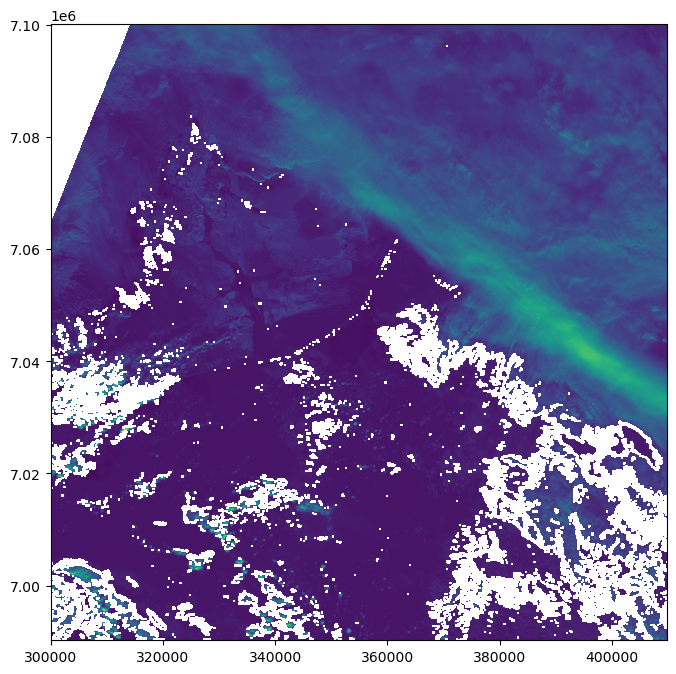

In [208]:
import rasterio as rio
from rasterio.plot import show

# Read and plot with grid coordinates 
with rio.open(earthaccess.open(granule_list[2:3])[2]) as src:
    fig, ax = plt.subplots(figsize=(9,8))

    # To plot
    show(src,1)

    # To open data into a numpy array
    profile = src.profile
    arr = src.read(1)

In [196]:
hls_scene = xr.open_dataset(earthaccess.open(granule_list[0:1])[0], engine='rasterio')
hls_scene

 Opening 1 granules, approx size: 0.22 GB


SUBMITTING | :   0%|          | 0/18 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/18 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/18 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:      (band: 1, x: 3660, y: 3660)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.097e+05
  * y            (y) float64 7.1e+06 7.1e+06 7.1e+06 ... 6.99e+06 6.99e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

### Working with legacy data formats

**MOD07_L2** is an HDF EOS dataset providing atmospheric profiles from the MODerate Resolution Imaging Spectroradiometer instrument on the Terra satelite. You could use this data for providing an atmospheric correction for imagery to get a surface reflectance measurement. 

It is in a very old HDF data format and although streaming is technically possible, the only libraries that can open HDF EOS expect file paths not remote file systems like the one used by xarray (fsspec). In this case we will be better off accesing the netCDF endpoint via Opendap to download the granules instead of streaming them.

In [ ]:
iceland_bbox = (-22.1649, 63.3052, -11.9366, 65.5970)

granules = earthaccess.search_data(
    short_name = "MOD07_L2",
    bounding_box = iceland_bbox,
    temporal = (f"2020-01-01", f"2020-01-02")
)

In [211]:
print("Direct access link: ", granules[0].data_links(access="direct"))
print("External link: ", granules[0].data_links(access="external"))

Direct access link:  ['s3://prod-lads/MOD07_L2/MOD07_L2.A2020001.0015.061.2020002183420.hdf']
External link:  ['https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD07_L2/2020/001/MOD07_L2.A2020001.0015.061.2020002183420.hdf']


If we try to open these hdf files in xarray...

In [ ]:
mod07 = xr.open_mfdataset(earthaccess.open(granule_list[0:3]))

We notice that the access occurs quickly, but xarray is unable to recognize the legacy file format. HDF files are remarkably hard to open. You must download the files and open using pyhdf to open them using code like this: 
`from pyhdf.SD import SD,SDC` \
`mod07_l2 = SD(MODfile, SDC.READ)`

We do have another option to convert to nc4 files during download so that we can open the files in xarray.

In [213]:
# This method should be public in upcoming versions of earthaccess
granules[0]._filter_related_links("USE SERVICE API")

['https://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD07_L2/2020/001/MOD07_L2.A2020001.0015.061.2020002183420.hdf.html']

In [219]:
netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in granules]
netcdf_list[0]

'https://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD07_L2/2020/001/MOD07_L2.A2020001.0015.061.2020002183420.hdf.nc4'

In [220]:
# This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
# and Opendap is very prone to failures due concurrent connections, not ideal.
file_handlers = earthaccess.download(netcdf_list[0:3], local_path="test_data", threads=4)

SUBMITTING | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/3 [00:01<?, ?it/s]

COLLECTING | :   0%|          | 0/3 [00:00<?, ?it/s]

In [221]:
# Get the file names
path = "test_data"
dir_list = os.listdir(path)
print(dir_list)

['MOD07_L2.A2020001.0015.061.2020002183420.hdf.nc4', 'MOD07_L2.A2020001.1335.061.2020002184119.hdf.nc4', 'MOD07_L2.A2020001.1200.061.2020002184553.hdf.nc4']


In [222]:
cd test_data

/home/jovyan/CryoCloudWebsite/book/tutorials/IS2_ATL15_surface_height_anomalies/test_data


In [223]:
# Open a file into xarray for analysis
ds = xr.open_dataset(dir_list[0])
ds

<xarray.Dataset>
Dimensions:                            (Band_Number: 12, Pressure_Level: 20,
                                        Cell_Along_Swath: 406,
                                        Cell_Across_Swath: 270,
                                        Output_Parameter: 10,
                                        Water_Vapor_QA_Bytes: 5)
Coordinates:
  * Band_Number                        (Band_Number) int32 24 25 27 ... 34 35 36
  * Pressure_Level                     (Pressure_Level) float32 5.0 ... 1e+03
    Latitude                           (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Longitude                          (Cell_Along_Swath, Cell_Across_Swath) float32 ...
  * Output_Parameter                   (Output_Parameter) int32 0 1 2 ... 7 8 9
  * Water_Vapor_QA_Bytes               (Water_Vapor_QA_Bytes) int32 0 1 2 3 4
Dimensions without coordinates: Cell_Along_Swath, Cell_Across_Swath
Data variables: (12/29)
    Pressure_Levels                    (Pressure_Level) int16 ...
    Scan_Start_Time                    (Cell_Along_Swath, Cell_Across_Swath) datetime64[ns] ...
    Solar_Zenith                       (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Solar_Azimuth                      (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Sensor_Zenith                      (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Sensor_Azimuth                     (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    ...                                 ...
    Water_Vapor                        (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Water_Vapor_Direct                 (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Water_Vapor_Low                    (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Water_Vapor_High                   (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Quality_Assurance                  (Cell_Along_Swath, Cell_Across_Swath, Output_Parameter) float64 ...
    Quality_Assurance_Infrared         (Cell_Along_Swath, Cell_Across_Swath, Water_Vapor_QA_Bytes) float64 ...
Attributes:
    HDFEOSVersion:                      HDFEOS_V2.19
    ScaleFactor_AddOffset_Application:  Value=scale_factor*(stored integer - ...
    Pressure_Levels:                    5, 10, 20, 30, 50, 70, 100, 150, 200,...
    title:                              MODIS Level 2 Atmospheric Profiles   ...
    identifier_product_doi:             10.5067/MODIS/MOD07_L2.061
    identifier_product_doi_authority:   http://dx.doi.org
    history:                            $Id: MOD07.V2.CDL,v 1.1 2005/12/14 16...
    history_json:                       [{"$schema":"https:\/\/harmony.earthd...